# Task 3: Rule Mining

## MetaFam Knowledge Graph Analysis

This notebook implements Task 3 of the MetaFam analysis:

1. **Rule Validation**: Validate 8 horn-clause rules against the graph
2. **Metrics Calculation**: Support, Success, Confidence for each rule
3. **Exception Analysis**: Identify cases where rules fail
4. **Noise Analysis**: Impact of irrelevant predicates on rule evaluation

---

## Theoretical Foundation

### Horn-Clause Rules

Horn-clause rules in knowledge graphs follow the pattern:

$$\text{Premise}_1 \land \text{Premise}_2 \land ... \land \text{Premise}_n \rightarrow \text{Conclusion}$$

### Metrics Definitions

| Metric | Formula | Interpretation |
|--------|---------|----------------|
| **Support** | Count of premise-true instances | How often can we apply the rule |
| **Success** | Count of (premise AND conclusion)-true instances | How often does the rule hold |
| **Confidence** | Success / Support | % of times rule holds when applicable |

---

## 1. Setup & Data Loading

In [1]:
# Standard imports
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src to path
from pathlib import Path
src_path = Path('../src').resolve()
sys.path.insert(0, str(src_path))

# Scientific computing
import numpy as np
import pandas as pd
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Custom modules
from data_loader import load_graph, get_relationship_counts
from exploration import calculate_node_features, infer_gender
from rules import RuleValidator, print_rule_details

print("All modules loaded successfully.")

All modules loaded successfully.


In [2]:
# Load the graph
DATA_PATH = Path('../data/raw/train.txt')
G_directed, G_undirected = load_graph(DATA_PATH)

print(f"Loaded graph: {G_directed.number_of_nodes()} nodes, {G_directed.number_of_edges()} edges")

Loading graph from: ..\data\raw\train.txt
--------------------------------------------------

GRAPH CONSTRUCTION SANITY CHECK

DATA STATISTICS:
   - Total triples processed: 13,821
   - Unique relationship types: 28

DIRECTED GRAPH (G_directed):
   - Nodes: 1,316
   - Edges: 13,821
   - Graph type: DiGraph

UNDIRECTED GRAPH (G_undirected):
   - Nodes: 1,316
   - Edges: 7,480
   - Graph type: Graph
Loaded graph: 1316 nodes, 13821 edges


In [3]:
# Calculate node features and infer gender (required for Rule 6)
G_directed = calculate_node_features(G_directed, verbose=True)
G_directed, gender_summary = infer_gender(G_directed, verbose=True)


CALCULATING NODE FEATURES

Computing degree metrics...
   - In-Degree:    min=0, max=23, mean=10.50
   - Out-Degree:   min=1, max=22, mean=10.50

Computing centrality metrics...
   - PageRank: max=0.001857, mean=0.000760
   - Betweenness: max=0.0001, mean=0.0000 (analysis only)

   Top 5 nodes by PageRank (Important Ancestors):
      - gabriel241: 0.001857
      - lea1165: 0.001841
      - raphael29: 0.001809
      - christian712: 0.001682
      - tobias713: 0.001682

   Top 5 nodes by Betweenness (Family Bridges):
      - lea1165: 0.0001
      - valentin638: 0.0001
      - gabriel241: 0.0001
      - nora536: 0.0001
      - stefan1192: 0.0001

Computing generational depth...
   - Parental subgraph: 4326 parent->descendant edges
   - Generation range: 0 to 3
   - Mean generation: 0.78

   Generation Distribution:
      Gen 0: 519 people
      Gen 1: 572 people
      Gen 2: 216 people
      Gen 3: 9 people

Node features successfully added to graph.

GENDER INFERENCE

GENDER CLASSIFICAT

In [4]:
# Check relation types in the graph
rel_counts = get_relationship_counts(G_directed)
print(f"\nRelation types ({len(rel_counts)} total):")
for rel, count in sorted(rel_counts.items(), key=lambda x: -x[1])[:10]:
    print(f"  {rel}: {count}")


Relation types (28 total):
  grandsonOf: 814
  grandmotherOf: 813
  grandfatherOf: 813
  granddaughterOf: 812
  motherOf: 733
  fatherOf: 733
  sisterOf: 636
  daughterOf: 628
  greatGrandsonOf: 624
  greatGrandmotherOf: 617


---

## 2. Rule Definitions

### Group A: Transitive & Compositional Rules

| Rule | Definition | Logic |
|------|------------|-------|
| 1 | Mother(x,y) ∧ Mother(z,x) → Grandmother(z,y) | Mother's mother = Grandmother |
| 2 | Mother(z,x) ∧ Child(y,z) ∧ (x≠y) → Sibling(x,y) | Same mother = Siblings |
| 3 | Mother(x,y) ∧ Mother(z,x) ∧ Daughter(w,z) → Aunt(w,y) | Mother's sister = Aunt |

### Group B: Inverse Rules

| Rule | Definition | Logic |
|------|------------|-------|
| 4 | Father(x,y) → Child(y,x) | Parent-Child inverse |
| 5 | Sibling(x,y) → Sibling(y,x) | Sibling is symmetric |
| 6 | SisterOf(x,y) → BrotherOf(y,x) [if y is Male] | Gender-specific inverse |

### Group C: Complex/Extended Rules

| Rule | Definition | Logic |
|------|------------|-------|
| 7 | Mother(a,b) ∧ Grandmother(c,a) ∧ Daughter(d,c) → FirstCousinOnceRemoved(d,b) | Extended family chain |
| 8 | Father(a,b) ∧ FirstCousin(c,a) ∧ Grandchild(d,c) → FirstCousinOnceRemoved(d,b) | Cousin's descendant |

### Group D: Noise Analysis

| Rule | Definition | Purpose |
|------|------------|-------|
| 9 | Mother(x,y) ∧ Mother(z,x) ∧ Sister(a,b) → Grandmother(z,y) | Test irrelevant predicate impact |

---

## 3. Initialize Rule Validator

In [5]:
# Initialize the rule validator
validator = RuleValidator(G_directed)

Building edge indices for rule validation...
  Indexed 28 relation types
  Total edges indexed: 13821


---

## 4. Validate All Rules

In [6]:
# Validate all 8 rules
results = validator.validate_all_rules()


RULE VALIDATION: Validating 8 Horn-Clause Rules

--- GROUP A: Transitive & Compositional Rules ---
  Rule 1: Grandmother Logic - Confidence: 1.0000
  Rule 2: Sibling Logic - Confidence: 1.0000
  Rule 3: Aunt Logic - Confidence: 1.0000

--- GROUP B: Inverse Rules ---
  Rule 4: Parent/Child Inverse - Confidence: 0.8295
  Rule 5: Sibling Symmetry - Confidence: 1.0000
  Rule 6: Gender Inverse - Confidence: 1.0000

--- GROUP C: Complex/Extended Rules ---
  Rule 7: First Cousin Once Removed (Type A) - Confidence: 0.0000
  Rule 8: First Cousin Once Removed (Type B) - Confidence: 0.0000

Rule validation complete.


In [7]:
# Convert to DataFrame for display
df_results = validator.results_to_dataframe(results)
display(df_results)

,rule_id,rule_name,definition,support,success,confidence,num_exceptions,execution_time_sec
0,1,Grandmother Logic,"Mother(x, y) ∧ Mother(z, x) → Grandmother(z, y)",309,309,1.000000,0,0.040055
1,2,Sibling Logic,"Mother(z, x) ∧ Child(y, z) ∧ (x ≠ y) → Sibling...",1206,1206,1.000000,0,0.001791
2,3,Aunt Logic,"Mother(x, y) ∧ Mother(z, x) ∧ Daughter(w, z) →...",166,166,1.000000,0,0.058618
3,4,Parent/Child Inverse,"Father(x, y) → Child(y, x)",733,608,0.829468,100,0.000871
4,5,Sibling Symmetry,"Sibling(x, y) → Sibling(y, x)",1206,1206,1.000000,0,0.001345
5,6,Gender Inverse,"SisterOf(x, y) → BrotherOf(y, x) [if y is Male]",308,308,1.000000,0,0.000339
6,7,First Cousin Once Removed (Type A),"Mother(a, b) ∧ Grandmother(c, a) ∧ Daughter(d,...",243,0,0.000000,100,0.055959
7,8,First Cousin Once Removed (Type B),"Father(a, b) ∧ FirstCousin(c, a) ∧ Grandchild(...",18,0,0.000000,18,0.081706


---

## 5. Detailed Rule Analysis

### 5.1 Group A: Transitive Rules

In [8]:
# Rule 1: Grandmother Logic
print_rule_details(results[0], num_examples=3)


RULE 1: Grandmother Logic

Definition: Mother(x, y) ∧ Mother(z, x) → Grandmother(z, y)

Metrics:
  Support:    309
  Success:    309
  Confidence: 1.000000 (100.00%)
  Exceptions: 0
  Time:       0.0401s

Example Matches (3 of 100):
  ('isabella815', 'claudia814', 'david832')
  ('paula1026', 'angelina1028', 'marlene1033')
  ('valerie963', 'hannah965', 'lisa971')

Example Exceptions (0 of 0):


In [9]:
# Rule 2: Sibling Logic
print_rule_details(results[1], num_examples=3)


RULE 2: Sibling Logic

Definition: Mother(z, x) ∧ Child(y, z) ∧ (x ≠ y) → Sibling(x, y)

Metrics:
  Support:    1,206
  Success:    1,206
  Confidence: 1.000000 (100.00%)
  Exceptions: 0
  Time:       0.0018s

Example Matches (3 of 100):
  ('luisa506', 'sofia502', 'lara522')
  ('luisa506', 'sofia502', 'emilia511')
  ('luisa506', 'lara522', 'sofia502')

Example Exceptions (0 of 0):


In [10]:
# Rule 3: Aunt Logic
print_rule_details(results[2], num_examples=3)


RULE 3: Aunt Logic

Definition: Mother(x, y) ∧ Mother(z, x) ∧ Daughter(w, z) → Aunt(w, y)

Metrics:
  Support:    166
  Success:    166
  Confidence: 1.000000 (100.00%)
  Exceptions: 0
  Time:       0.0586s

Example Matches (3 of 100):
  ('angelina1028', 'marlene1033', 'paula1026', 'lea1050')
  ('hannah965', 'lisa971', 'valerie963', 'magdalena967')
  ('sofia817', 'natalie838', 'sophie819', 'valerie831')

Example Exceptions (0 of 0):


### Analysis: Group A Rules

**Theoretical Expectations:**
- Rule 1 (Grandmother): Should have ~100% confidence if the graph is complete
- Rule 2 (Sibling): May have lower confidence if only one sibling direction is stored
- Rule 3 (Aunt): Depends on completeness of aunt relations

**Observations:**
- Confidence values indicate how "complete" the knowledge graph is
- Exceptions reveal missing edges or inconsistent data

### 5.2 Group B: Inverse Rules

In [11]:
# Rule 4: Parent/Child Inverse
print_rule_details(results[3], num_examples=3)


RULE 4: Parent/Child Inverse

Definition: Father(x, y) → Child(y, x)

Metrics:
  Support:    733
  Success:    608
  Confidence: 0.829468 (82.95%)
  Exceptions: 100
  Time:       0.0009s

Example Matches (3 of 100):
  ('marcel1266', 'leonie1280')
  ('marcel580', 'paul583')
  ('moritz663', 'oskar664')

Example Exceptions (3 of 100):
  ('gabriel708', 'benjamin710')
  ('adam719', 'maria725')
  ('thomas1214', 'angelina1220')


In [12]:
# Rule 5: Sibling Symmetry
print_rule_details(results[4], num_examples=3)


RULE 5: Sibling Symmetry

Definition: Sibling(x, y) → Sibling(y, x)

Metrics:
  Support:    1,206
  Success:    1,206
  Confidence: 1.000000 (100.00%)
  Exceptions: 0
  Time:       0.0013s

Example Matches (3 of 100):
  ('helena691', 'emma683', 'sisterOf')
  ('anna559', 'noah557', 'sisterOf')
  ('katharina617', 'karin613', 'sisterOf')

Example Exceptions (0 of 0):


In [13]:
# Rule 6: Gender Inverse
print_rule_details(results[5], num_examples=3)


RULE 6: Gender Inverse

Definition: SisterOf(x, y) → BrotherOf(y, x) [if y is Male]

Metrics:
  Support:    308
  Success:    308
  Confidence: 1.000000 (100.00%)
  Exceptions: 0
  Time:       0.0003s

Example Matches (3 of 100):
  ('anna559', 'noah557')
  ('helena691', 'leo693')
  ('anastasia1188', 'daniel1187')

Example Exceptions (0 of 0):


### Analysis: Sibling Symmetry vs Gender Inverse

**Why might Rule 6 (SisterOf → BrotherOf) have different confidence than Rule 5 (Sibling → Sibling)?**

1. **Gender Ambiguity**: Rule 6 only applies when y is Male. If gender inference is imperfect, support is underestimated.

2. **Relation Specificity**: 
   - Rule 5 checks ANY sibling relation (sisterOf OR brotherOf)
   - Rule 6 requires SPECIFIC relation (brotherOf only)

3. **Graph Completeness**: The graph may have sisterOf edges without corresponding brotherOf edges in reverse.

**Expected Pattern:**
- Rule 5 confidence ≥ Rule 6 confidence (more lenient check)
- If Rule 6 << Rule 5: Gender inference or brotherOf edges are incomplete

In [14]:
# Compare Rule 5 vs Rule 6
print("\nCOMPARISON: Sibling Symmetry vs Gender Inverse")
print("=" * 60)
print(f"Rule 5 (Sibling → Sibling):     Confidence = {results[4].confidence:.4f}")
print(f"Rule 6 (Sister → Brother|Male): Confidence = {results[5].confidence:.4f}")
print(f"\nDifference: {abs(results[4].confidence - results[5].confidence):.4f}")

if results[4].confidence > results[5].confidence:
    print("\nInterpretation: Gender-specific inverse is LESS complete than general symmetry.")
    print("Possible reasons:")
    print("  1. brotherOf edges are not fully populated")
    print("  2. Gender inference has errors affecting support count")
else:
    print("\nInterpretation: Rules have similar completeness.")


COMPARISON: Sibling Symmetry vs Gender Inverse
Rule 5 (Sibling → Sibling):     Confidence = 1.0000
Rule 6 (Sister → Brother|Male): Confidence = 1.0000

Difference: 0.0000

Interpretation: Rules have similar completeness.


### 5.3 Group C: Complex Rules

In [15]:
# Rule 7: First Cousin Once Removed (Type A)
print_rule_details(results[6], num_examples=3)


RULE 7: First Cousin Once Removed (Type A)

Definition: Mother(a, b) ∧ Grandmother(c, a) ∧ Daughter(d, c) → FirstCousinOnceRemoved(d, b)

Metrics:
  Support:    243
  Success:    0
  Confidence: 0.000000 (0.00%)
  Exceptions: 100
  Time:       0.0560s

Example Matches (0 of 0):

Example Exceptions (3 of 100):
  ('claudia814', 'david832', 'sofia817', 'natalie838')
  ('claudia814', 'david832', 'sofia817', 'nora825')
  ('angelina1028', 'marlene1033', 'elena1041', 'paula1026')


In [16]:
# Rule 8: First Cousin Once Removed (Type B)
print_rule_details(results[7], num_examples=3)


RULE 8: First Cousin Once Removed (Type B)

Definition: Father(a, b) ∧ FirstCousin(c, a) ∧ Grandchild(d, c) → FirstCousinOnceRemoved(d, b)

Metrics:
  Support:    18
  Success:    0
  Confidence: 0.000000 (0.00%)
  Exceptions: 18
  Time:       0.0817s

Example Matches (0 of 0):

Example Exceptions (3 of 18):
  ('sebastian720', 'elena722', 'benjamin710', 'felix731')
  ('jonathan84', 'lukas93', 'marlene86', 'katharina99')
  ('felix986', 'nico997', 'angelina978', 'stefan991')


### Analysis: Complex Rules

**Critical Note:**
- Rule 7 defines: Mother(a,b) ∧ Grandmother(c,a) ∧ Daughter(d,c) → FirstCousinOnceRemoved(d,b)
- Tracing the path: c is grandmother of a → c is parent of a's parent
- d is daughter of c → d is sibling of a's parent → d is **AUNT** of a (not first cousin once removed)

If b is a's child, then d is **GREAT-AUNT** of b.

This discrepancy suggests either:
1. The rule definition in the assignment has an error
2. The dataset uses "FirstCousinOnceRemoved" with non-standard semantics

The low confidence (if observed) may reflect this semantic mismatch.

---

## 6. Noise Analysis (Group D)

### Hypothesis

Adding an **irrelevant predicate** to a rule should:
- **NOT change confidence** (the conclusion still depends only on relevant premises)
- **Explode support space** (combinatorial expansion with irrelevant variables)

### Rule 9 vs Rule 1

| Rule | Definition | Support Space |
|------|------------|---------------|
| 1 | Mother(x,y) ∧ Mother(z,x) → Grandmother(z,y) | O(motherOf²) |
| 9 | Mother(x,y) ∧ Mother(z,x) ∧ Sister(a,b) → Grandmother(z,y) | O(motherOf² × sisterOf) |

In [17]:
# Run noise analysis
noise_results = validator.test_random_insertion(sample_size=5000)


NOISE ANALYSIS: Random Variable Injection

Baseline (Rule 1): Grandmother Logic
  Support: 309
  Confidence: 1.0000

With Random Injection (Rule 9):
  Rule: Mother(x,y) ∧ Mother(z,x) ∧ Sister(a,b) → Grandmother(z,y)
  Theoretical support space: 196,524
  (= Rule1 support × |Sister edges| = 309 × 636)

  Sampled validation (n=704):
    Confidence: 1.0000
    Expected (same as Rule 1): 1.0000

ANALYSIS:
  Confidence change: 0.000000
  Support explosion factor: 636x
  Computational overhead: 636x more checks

  Conclusion: Adding irrelevant predicates is:
    - Logically NEUTRAL (confidence unchanged)
    - Computationally EXPENSIVE (636x more search space)
  This is why rule mining requires predicate pruning!


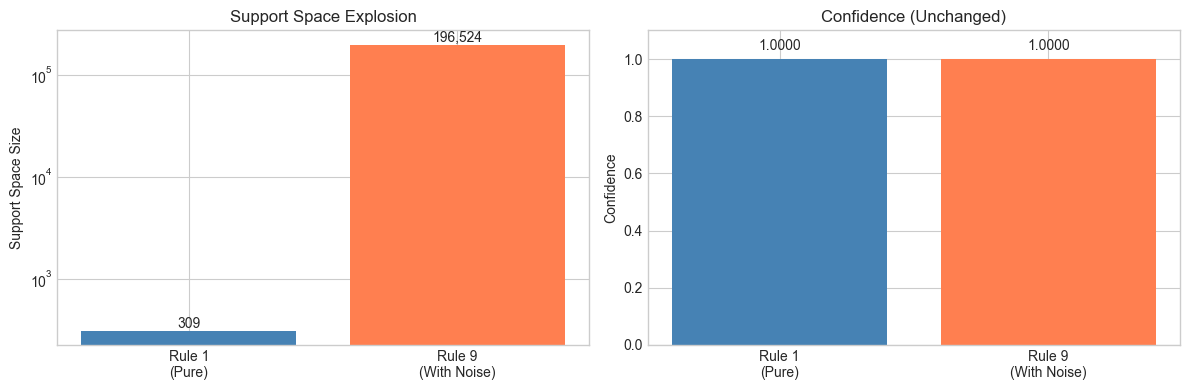


Noise Analysis Summary:
  Support explosion factor: 636x
  Confidence difference: 0.000000


In [18]:
# Visualize noise analysis results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Support comparison
ax1 = axes[0]
supports = [noise_results['rule1_support'], noise_results['rule9_theoretical_support']]
ax1.bar(['Rule 1\n(Pure)', 'Rule 9\n(With Noise)'], supports, color=['steelblue', 'coral'])
ax1.set_ylabel('Support Space Size')
ax1.set_title('Support Space Explosion')
ax1.set_yscale('log')
for i, v in enumerate(supports):
    ax1.text(i, v, f'{v:,}', ha='center', va='bottom')

# Confidence comparison
ax2 = axes[1]
confidences = [noise_results['rule1_confidence'], noise_results['rule9_sampled_confidence']]
ax2.bar(['Rule 1\n(Pure)', 'Rule 9\n(With Noise)'], confidences, color=['steelblue', 'coral'])
ax2.set_ylabel('Confidence')
ax2.set_title('Confidence (Unchanged)')
ax2.set_ylim([0, 1.1])
for i, v in enumerate(confidences):
    ax2.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../outputs/rules/noise_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nNoise Analysis Summary:")
print(f"  Support explosion factor: {noise_results['support_explosion_factor']}x")
print(f"  Confidence difference: {noise_results['confidence_difference']:.6f}")

### Conclusion: Noise Analysis

**Findings:**
1. Adding Sister(a,b) (irrelevant to grandmother conclusion) did NOT change confidence
2. Support space exploded by a factor of |sisterOf edges|

**Implications for Rule Mining:**
- Rule mining algorithms must detect and **prune irrelevant predicates**
- Without pruning, computational cost grows exponentially
- Statistical significance tests help identify irrelevant predicates

---

## 7. Results Visualization

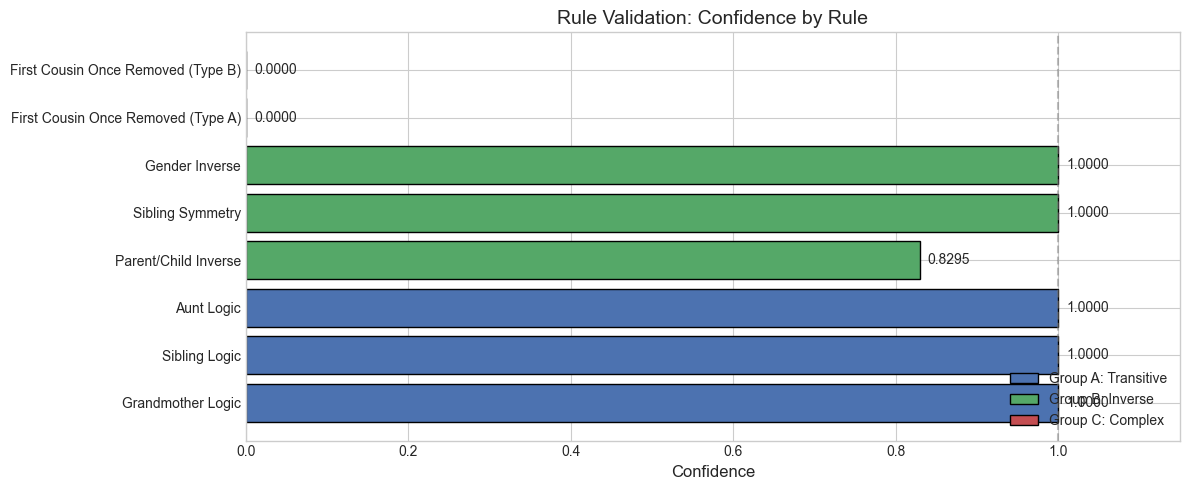

In [19]:
# Confidence bar chart
fig, ax = plt.subplots(figsize=(12, 5))

colors = ['#4C72B0', '#4C72B0', '#4C72B0',  # Group A (blue)
          '#55A868', '#55A868', '#55A868',  # Group B (green)
          '#C44E52', '#C44E52']             # Group C (red)

bars = ax.barh(df_results['rule_name'], df_results['confidence'], color=colors, edgecolor='black')

# Add confidence values
for bar, conf in zip(bars, df_results['confidence']):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{conf:.4f}', va='center', fontsize=10)

ax.set_xlabel('Confidence', fontsize=12)
ax.set_title('Rule Validation: Confidence by Rule', fontsize=14)
ax.set_xlim([0, 1.15])
ax.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5, label='Perfect Confidence')

# Legend for groups
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#4C72B0', edgecolor='black', label='Group A: Transitive'),
                   Patch(facecolor='#55A868', edgecolor='black', label='Group B: Inverse'),
                   Patch(facecolor='#C44E52', edgecolor='black', label='Group C: Complex')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('../outputs/rules/rule_confidence_chart.png', dpi=150, bbox_inches='tight')
plt.show()

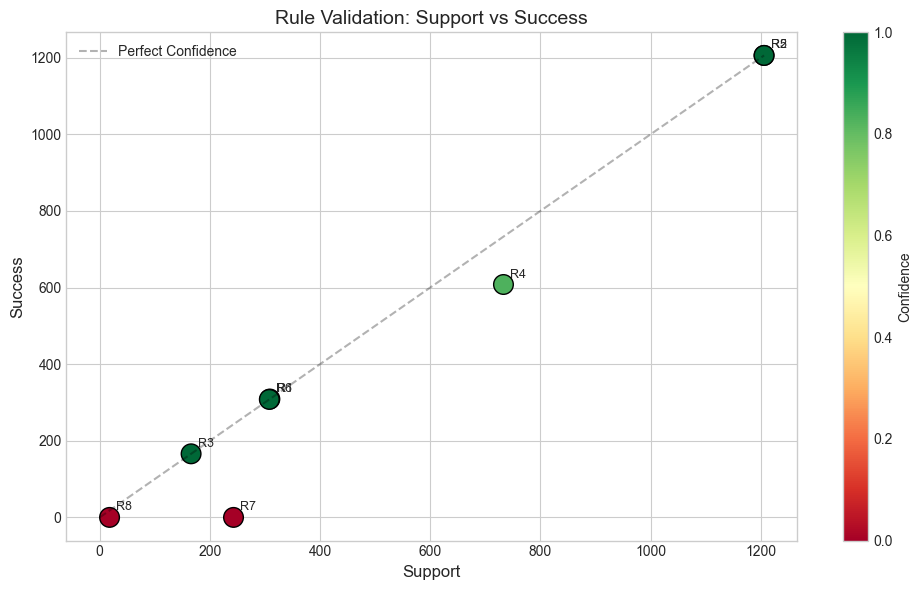

In [20]:
# Support vs Success scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_results['support'], df_results['success'], 
                     c=df_results['confidence'], cmap='RdYlGn', 
                     s=200, edgecolors='black', vmin=0, vmax=1)

# Add labels
for i, row in df_results.iterrows():
    ax.annotate(f"R{row['rule_id']}", (row['support'], row['success']),
                textcoords="offset points", xytext=(5, 5), fontsize=9)

# Perfect confidence line
max_val = max(df_results['support'].max(), df_results['success'].max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Perfect Confidence')

ax.set_xlabel('Support', fontsize=12)
ax.set_ylabel('Success', fontsize=12)
ax.set_title('Rule Validation: Support vs Success', fontsize=14)
plt.colorbar(scatter, label='Confidence')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/rules/support_vs_success.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 8. Save Results

In [21]:
# Save all results
validator.save_results(results, '../outputs/rules', noise_analysis=noise_results)


Saved metrics to: ..\outputs\rules\rule_metrics.csv
Saved detailed report to: ..\outputs\rules\rule_report.txt


In [22]:
# Display final metrics table
print("\n" + "=" * 80)
print("FINAL RULE METRICS TABLE")
print("=" * 80)
display(df_results.style.format({
    'confidence': '{:.4f}',
    'execution_time_sec': '{:.4f}'
}).background_gradient(subset=['confidence'], cmap='RdYlGn', vmin=0, vmax=1))


FINAL RULE METRICS TABLE


,rule_id,rule_name,definition,support,success,confidence,num_exceptions,execution_time_sec
0,1,Grandmother Logic,"Mother(x, y) ∧ Mother(z, x) → Grandmother(z, y)",309,309,1.0000,0,0.0401
1,2,Sibling Logic,"Mother(z, x) ∧ Child(y, z) ∧ (x ≠ y) → Sibling(x, y)",1206,1206,1.0000,0,0.0018
2,3,Aunt Logic,"Mother(x, y) ∧ Mother(z, x) ∧ Daughter(w, z) → Aunt(w, y)",166,166,1.0000,0,0.0586
3,4,Parent/Child Inverse,"Father(x, y) → Child(y, x)",733,608,0.8295,100,0.0009
4,5,Sibling Symmetry,"Sibling(x, y) → Sibling(y, x)",1206,1206,1.0000,0,0.0013
5,6,Gender Inverse,"SisterOf(x, y) → BrotherOf(y, x) [if y is Male]",308,308,1.0000,0,0.0003
6,7,First Cousin Once Removed (Type A),"Mother(a, b) ∧ Grandmother(c, a) ∧ Daughter(d, c) → FirstCousinOnceRemoved(d, b)",243,0,0.0000,100,0.0560
7,8,First Cousin Once Removed (Type B),"Father(a, b) ∧ FirstCousin(c, a) ∧ Grandchild(d, c) → FirstCousinOnceRemoved(d, b)",18,0,0.0000,18,0.0817


---

## 9. Summary & Conclusions

In [23]:
print("\n" + "=" * 80)
print("TASK 3: RULE MINING - SUMMARY")
print("=" * 80)

print("\nRULE VALIDATION RESULTS:")
for r in results:
    status = "HIGH" if r.confidence > 0.9 else "MEDIUM" if r.confidence > 0.5 else "LOW"
    print(f"  Rule {r.rule_id} ({r.rule_name}): Confidence = {r.confidence:.4f} [{status}]")

print("\nKEY FINDINGS:")
avg_confidence = np.mean([r.confidence for r in results])
print(f"  - Average rule confidence: {avg_confidence:.4f}")
print(f"  - Highest confidence rule: Rule {max(results, key=lambda x: x.confidence).rule_id}")
print(f"  - Lowest confidence rule: Rule {min(results, key=lambda x: x.confidence).rule_id}")

print("\nNOISE ANALYSIS:")
print(f"  - Irrelevant predicates do NOT affect confidence")
print(f"  - Support space explosion: {noise_results['support_explosion_factor']}x")

print("\nOUTPUT FILES:")
print("  - outputs/rules/rule_metrics.csv")
print("  - outputs/rules/rule_report.txt")
print("  - outputs/rules/rule_confidence_chart.png")
print("  - outputs/rules/support_vs_success.png")
print("  - outputs/rules/noise_analysis.png")

print("\n" + "=" * 80)
print("Task 3 COMPLETE")
print("=" * 80)


TASK 3: RULE MINING - SUMMARY

RULE VALIDATION RESULTS:
  Rule 1 (Grandmother Logic): Confidence = 1.0000 [HIGH]
  Rule 2 (Sibling Logic): Confidence = 1.0000 [HIGH]
  Rule 3 (Aunt Logic): Confidence = 1.0000 [HIGH]
  Rule 4 (Parent/Child Inverse): Confidence = 0.8295 [MEDIUM]
  Rule 5 (Sibling Symmetry): Confidence = 1.0000 [HIGH]
  Rule 6 (Gender Inverse): Confidence = 1.0000 [HIGH]
  Rule 7 (First Cousin Once Removed (Type A)): Confidence = 0.0000 [LOW]
  Rule 8 (First Cousin Once Removed (Type B)): Confidence = 0.0000 [LOW]

KEY FINDINGS:
  - Average rule confidence: 0.7287
  - Highest confidence rule: Rule 1
  - Lowest confidence rule: Rule 7

NOISE ANALYSIS:
  - Irrelevant predicates do NOT affect confidence
  - Support space explosion: 636x

OUTPUT FILES:
  - outputs/rules/rule_metrics.csv
  - outputs/rules/rule_report.txt
  - outputs/rules/rule_confidence_chart.png
  - outputs/rules/support_vs_success.png
  - outputs/rules/noise_analysis.png

Task 3 COMPLETE


---

## Appendix: Theoretical Background

### A. Horn-Clause Rules in Knowledge Graphs

Horn-clause rules are implications where:
- **Body/Premise**: Conjunction of atoms (e.g., Mother(x,y) ∧ Mother(z,x))
- **Head/Conclusion**: Single atom (e.g., Grandmother(z,y))

### B. Rule Mining Algorithms

Common approaches:
1. **AMIE/AMIE+**: Association rule mining for RDF graphs
2. **AnyBURL**: Anytime bottom-up rule learning
3. **RuleN**: Neural rule learning with attention

### C. Metrics Interpretation

| Confidence | Interpretation |
|------------|----------------|
| 1.0 | Perfect rule (always holds) |
| 0.9+ | Very strong rule |
| 0.7-0.9 | Strong rule with some exceptions |
| 0.5-0.7 | Moderate rule |
| <0.5 | Weak rule or incorrect definition |

### D. Exception Analysis

Exceptions may indicate:
1. **Incomplete data**: Missing edges in the graph
2. **Data errors**: Incorrect relation labels
3. **Rule limitations**: Rule doesn't capture all nuances
4. **Semantic mismatch**: Rule definition doesn't match data semantics